In [8]:
import skorch
import torch
import torch.nn as nn
import numpy

In [441]:
import visdom
vis = visdom.Visdom()

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

numpy.random.seed(7)

In [4]:
T = 1000
X = numpy.array(range(T))
Y = numpy.sin(3.5 * numpy.pi * X / T) 

# draw training data

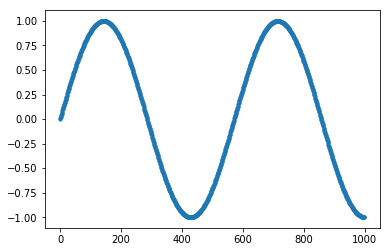

In [5]:
plt.scatter(X, Y, s = 10)
plt.show()

# build model

In [655]:
class Model(nn.Module):
    def __init__(self, one_hot=False, act='tanh', deep=True, num_layers=9):
        super().__init__()
        
        num_input = 1000 if one_hot else 1
        
        if act == 'relu':
            self.act = nn.ReLU()
        else:
            self.act = nn.Tanh()
        self.clf = nn.Tanh()
        self.layers = []
        if deep:
            self.layers.append(nn.Linear(num_input, 10))
            self.layers.append(nn.Linear(10, 90))
            self.layers.append(nn.Linear(90, 10))
            for i in range(num_layers):
                self.layers.append(nn.Linear(10, 10))
            self.layers.append(nn.Linear(10, 1))
        else:
            self.layers.append(nn.Linear(num_input, 90))
            self.layers.append(nn.Linear(90, 1))
        
        for i, l in enumerate(self.layers):
            self.add_module('linear_{}'.format(i), l)
    def forward(self, x):
        for i, l in enumerate(self.layers[:-1]):
            x = self.act(l(x))
        x = self.layers[-1](x)
        #vis.heatmap(x.data.numpy(), win="act_{}".format(i))
        return x

# build trainer

In [641]:
class Trainer(skorch.NeuralNetRegressor):
    def get_loss(self, *args, **kwargs):
        l = super().get_loss(*args, **kwargs)
        l.backward(retain_graph=True)
#         print('({:.2},{:.2})'.format(kwargs['X'].min(), kwargs['X'].max()),
#              self.module_.layers[0].weight.grad.mean().data[0],
#              self.module_.layers[-1].weight.grad.mean().data[0])
        self.history.record_batch(
            'overall_grads', 
            numpy.mean([n.weight.grad.mean().data[0] for n in self.module_.layers]))
        return super().get_loss(*args, **kwargs)

In [617]:
#X_train = numpy.eye(len(X)).astype('float32')
#X_train = X.reshape(-1, 1).astype('float32')
X_train = ((X - X.mean())/X.std()).reshape(-1, 1).astype('float32')
Y_train = Y.reshape(-1, 1).astype('float32')

In [618]:
X_train.shape

(1000, 1)

In [594]:
Y_train.shape

(1000, 1)

# Shallow network

In [649]:
ef = Trainer(
    module=Model,
    optimizer=torch.optim.Adam,
    lr=0.002,
    max_epochs=60,
    batch_size=10,
    train_split=None,
    
    module__one_hot=False,
    module__deep=False,
    
    callbacks=[
        skorch.callbacks.Scoring(name='overall_grads', lower_is_better=False, scoring=grad_scoring, on_train=True)
    ]
)

In [650]:
ef.fit(X_train, Y_train)

  epoch    overall_grads    train_loss     dur
-------  ---------------  ------------  ------
      1           0.0008        0.1396  0.2060
      2          -0.0006        0.4209  0.2133
      3           0.0019        0.6459  0.2161
      4           0.0004        0.6443  0.2163
      5           0.0001        0.6544  0.2062
      6          -0.0009        0.6854  0.1996
      7          -0.0010        0.7014  0.2216
      8          -0.0009        0.7530  0.2169
      9          -0.0007        0.7727  0.1963
     10          -0.0008        0.7736  0.2130
     11          -0.0007        0.7344  0.2042
     12          -0.0007        0.6749  0.1982
     13          -0.0015        0.6024  0.2087
     14          -0.0017        0.5341  0.1991
     15          -0.0019        0.4673  0.2112
     16          -0.0020        0.4097  0.2193
     17          -0.0020        0.3609  0.1891
     18          -0.0019        0.3210  0.1959
     19          -0.0018        0.2893  0.1967
     20      

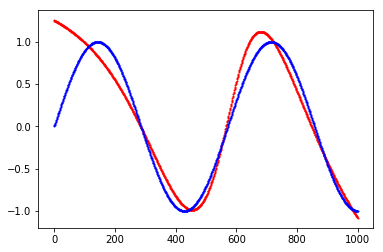

In [651]:
pred =  ef.predict(X_train)
x_plot = X
plt.scatter(x_plot, pred, s = 1, c =  'r')
plt.scatter(x_plot, Y, s = 1, c = 'b')

# Deep network (tanh)

In [659]:
def grad_scoring(net, X=None, y=None):
    return net.history[-1, 'batches', -1, 'overall_gradient']


ef = Trainer(
    module=Model,
    optimizer=torch.optim.Adam,
    lr=0.0002,
    max_epochs=500,
    batch_size=10,
    train_split=None,
    
    module__one_hot=False,
    module__deep=True,
    module__num_layers=9,
    module__act='tanh',
    
    callbacks=[
        skorch.callbacks.Scoring(name='overall_grads', lower_is_better=False, scoring=grad_scoring, on_train=True)
    ]
)

In [653]:
%pdb on
ef.fit(X_train, Y_train)

Automatic pdb calling has been turned ON
  epoch    overall_grads    train_loss     dur
-------  ---------------  ------------  ------
      1          -0.0014        0.6612  0.8365
      2          -0.0005        0.6039  0.7080
      3           0.0006        0.5999  0.6793
      4          -0.0009        0.5495  0.8271
      5          -0.0005        0.5125  0.7876
      6          -0.0003        0.4924  0.7787
      7           0.0000        0.4831  0.7447
      8          -0.0006        0.4818  0.7749
      9           0.0002        0.4782  0.7586
     10          -0.0004        0.4608  0.7647
     11          -0.0000        0.4578  0.7421
     12          -0.0005        0.4621  0.7765
     13          -0.0007        0.4560  0.7345
     14           0.0009        0.4518  0.6621
     15          -0.0026        0.4551  0.7032
     16           0.0015        0.4508  0.6837
     17          -0.0011        0.4344  0.7373
     18           0.0001        0.4278  0.7208
     19          -0

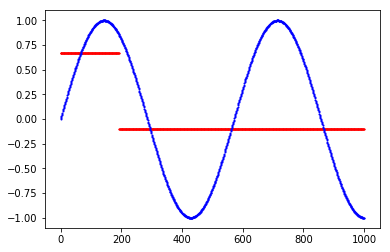

In [654]:
pred =  ef.predict(X_train)
x_plot = X
plt.scatter(x_plot, pred, s = 1, c =  'r')
plt.scatter(x_plot, Y, s = 1, c = 'b')

# Deep network (with ReLU)

In [659]:
def grad_scoring(net, X=None, y=None):
    return net.history[-1, 'batches', -1, 'overall_gradient']


ef = Trainer(
    module=Model,
    optimizer=torch.optim.Adam,
    lr=0.0002,
    max_epochs=500,
    batch_size=10,
    train_split=None,
    
    module__one_hot=False,
    module__deep=True,
    module__num_layers=9,
    module__act='relu',
    
    callbacks=[
        skorch.callbacks.Scoring(name='overall_grads', lower_is_better=False, scoring=grad_scoring, on_train=True)
    ]
)

In [660]:
%pdb on
ef.fit(X_train, Y_train)

Automatic pdb calling has been turned ON
  epoch    overall_grads    train_loss     dur
-------  ---------------  ------------  ------
      1          -0.0020        0.5076  1.1467
      2          -0.0016        0.5036  0.8754
      3          -0.0013        0.5020  1.0606
      4          -0.0011        0.5008  0.9230
      5          -0.0009        0.4999  0.8402
      6          -0.0008        0.4993  0.7489
      7          -0.0007        0.4988  0.8214
      8          -0.0006        0.4984  0.7936
      9          -0.0005        0.4982  0.8107
     10          -0.0004        0.4978  1.0120
     11          -0.0003        0.4975  1.3750
     12          -0.0003        0.4972  1.6050
     13          -0.0002        0.4968  1.8517
     14          -0.0002        0.4962  1.3366
     15          -0.0001        0.4951  0.7840
     16          -0.0000        0.4934  0.7787
     17           0.0001        0.4907  0.8498
     18           0.0001        0.4851  1.1762
     19           0

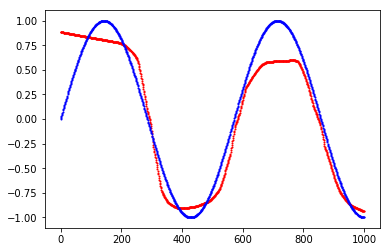

In [661]:
pred =  ef.predict(X_train)
x_plot = X
plt.scatter(x_plot, pred, s = 1, c =  'r')
plt.scatter(x_plot, Y, s = 1, c = 'b')